In [ ]:

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from skimage.io import imread
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
import keras.utils as image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras.backend as K
from keras.models import Sequential

use GPU for accelerated processing

#### Print directory name

In [ ]:
#preparing/accessing the images

#import
import os


for dirname, _, filenames in os.walk('/kaggle/input/bttai-nybg-2024'):
    print(dirname)




In [ ]:
# DataFrame
train_df = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train.csv")
val_df = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation.csv")
train_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train'
val_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation'
test_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test'
# val_df.head(10)
# os.listdir(test_dir)

# Symlink

In [ ]:

# Define the base directory where the actual images are stored
images_base_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train'

# Define the base directory where the symlinks will be stored
symlinks_base_dir = '/kaggle/working/training_symlinks'

# Create the symlinks directory if it doesn't already exist
os.makedirs(symlinks_base_dir, exist_ok=True)

# Iterate over the rows of the DataFrame and create symlinks
for index, row in train_df.iterrows():
    # Extract the image file name and class label from the DataFrame
    image_file_name = row['imageFile']
    class_label = row['classLabel']
    
    # Define the source path (actual location of the image)
    source_path = os.path.join(images_base_dir, image_file_name)
    
    # Define the target directory for the symlinks based on the class label
    class_dir = os.path.join(symlinks_base_dir, class_label)
    
    # Create a directory for the class if it doesn't already exist
    os.makedirs(class_dir, exist_ok=True)
    
    # Define the link path (where the symlink will be created)
    link_path = os.path.join(class_dir, image_file_name)
    
    # Create the symlink if the source file exists and the link does not exist yet
    if os.path.exists(source_path) and not os.path.exists(link_path):
        os.symlink(source_path, link_path)

print(f"Symlinks created in {symlinks_base_dir}")


In [ ]:

# Define the base directory where the actual images are stored
val_base_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation'

# Define the base directory where the symlinks will be stored
symlinks_base_dir_val = '/kaggle/working/val_symlinks'

# Create the symlinks directory if it doesn't already exist
os.makedirs(symlinks_base_dir_val, exist_ok=True)

# Iterate over the rows of the DataFrame and create symlinks
for index, row in val_df.iterrows():
    # Extract the image file name and class label from the DataFrame
    image_file_name = row['imageFile']
    class_label = row['classLabel']
    
    # Define the source path (actual location of the image)
    source_path = os.path.join(val_base_dir, image_file_name)
    
    # Define the target directory for the symlinks based on the class label
    class_dir = os.path.join(symlinks_base_dir_val, class_label)
    
    # Create a directory for the class if it doesn't already exist
    os.makedirs(class_dir, exist_ok=True)
    
    # Define the link path (where the symlink will be created)
    link_path = os.path.join(class_dir, image_file_name)
    
    # Create the symlink if the source file exists and the link does not exist yet
    if os.path.exists(source_path) and not os.path.exists(link_path):
        os.symlink(source_path, link_path)

print(f"Symlinks created in {symlinks_base_dir_val}")

In [ ]:
train_link = '/kaggle/working/training_symlinks'
val_link = '/kaggle/working/val_symlinks'


# Data Preprocessing
https://storage.googleapis.com/kaggle-forum-message-attachments/2710828/20481/Kaggle%20101%20w_%20Cindy.pdf


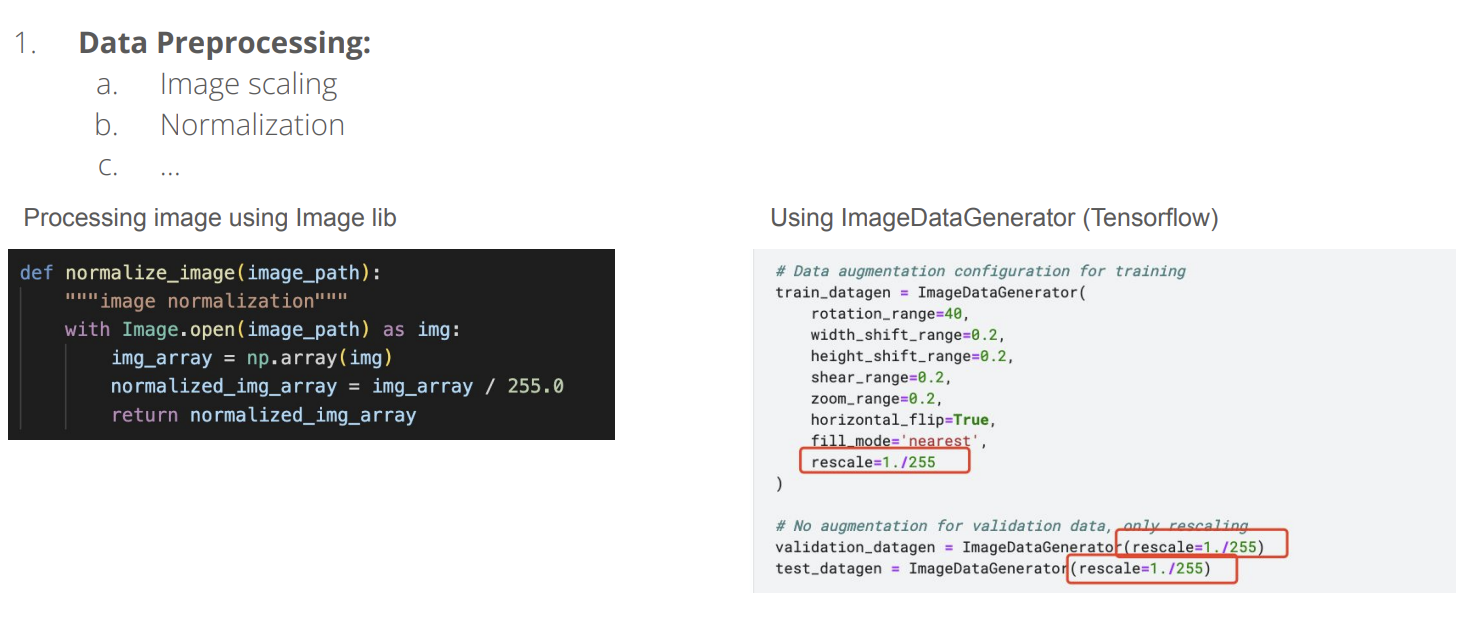

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
train_df_small, _ = train_test_split(train_df, test_size=0.90, random_state=42)
val_df_small, _ = train_test_split(val_df, test_size=0.95, random_state=42)


In [ ]:
#only preprocess training 
datagen_train=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
#   width_shift_range = 0.2,
#   height_shift_range = 0.2,
    fill_mode="nearest"                                                                                                                                                                                                                                                                                          
                                     
)


datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

## Flow from dataframe
https://keras.io/api/data_loading/image/

In [ ]:

train_dataset = datagen_train.flow_from_dataframe(
                dataframe = train_df_small,
                directory = train_dir,
                x_col = 'imageFile',#col with image filename 
                y_col = 'classLabel',#name of the column which contains the class names
                subset="training",
                batch_size=32,
                seed=42,
                shuffle=True,
                color_mode='rgb',
                interpolation='bicubic',
                class_mode="categorical",
                target_size=(256,256))
                    

#### Explore the images from train_dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch the next batch of images and labels
t_x, t_y = next(train_dataset)

# Create a figure with 16 subplots arranged in a 4x4 grid
fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))

# Reverse the class indices dictionary to map from indices to class names
index_to_class = {v: k for k, v in train_dataset.class_indices.items()}

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    # Display the image
    c_ax.imshow(c_x, vmin=-1.5, vmax=1.5)  # Removed the indexing to show all color channels
    
    # Decode the one-hot encoded label to get the class name
    # np.argmax will return the index of the max value, which corresponds to the class index
    label = index_to_class[np.argmax(c_y)]
    
    # Set the title of the subplot to the class name
    c_ax.set_title(label)
    
    # Turn off the axis
    c_ax.axis('off')

# Display the figure
plt.show()


In [ ]:

val_dataset = datagen.flow_from_dataframe(
                dataframe = val_df_small,
                directory = val_dir,
                x_col = 'imageFile',#col with image filename 
                y_col = 'classLabel',#name of the column which contains the class name                
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="categorical",
                target_size=(256,256))

# Image Augmentation and Data Pipeline


In [ ]:

training_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train'
batch = 521
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_link,
    labels='inferred', #label inferred from subdirectories containing images of each class
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch, #increase for
    image_size=(256, 256),
    shuffle=True,
    seed=None, #Optional random seed for shuffling and transformations.
    validation_split=None,
    subset=None,
    interpolation='bicubic', #interpolation method used when resizing images
    follow_links=False,
    crop_to_aspect_ratio=False,
    
)

In [ ]:
train_dataset
train_class = train_dataset.class_names
train_class


In [ ]:

batch = 521
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_link,
    labels='inferred', #label inferred from subdirectories containing images of each class
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch, #increase for
    image_size=(256, 256),
    shuffle=True,
    seed=None, #Optional random seed for shuffling and transformations.
    validation_split=None,
    subset=None,
    interpolation='bicubic', #interpolation method used when resizing images
    follow_links=False,
    crop_to_aspect_ratio=False,
    
)

In [ ]:
val_dataset
val_class = val_dataset.class_names
val_class

# Examine the processed images 

In [ ]:
from matplotlib import pyplot as plt
for images, labels in train_dataset.take(1):  # Take a single batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display first 9 images of the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        label = labels[i]
        
        # Convert label tensor to integer index
        label_index = labels[i].numpy()  # Convert TensorFlow tensor to numpy array
    
        title_label = train_class[tf.argmax(label_index).numpy()]  #convert one hot encoded numpy array to integer, then locate the class label 
        
        plt.title(title_label)
        plt.axis('off')

In [ ]:
for images, labels in val_dataset.take(1):  # Take a single batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display first 9 images of the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        label = labels[i]
        
        # Convert label tensor to integer index
        label_index = labels[i].numpy()  # Convert TensorFlow tensor to numpy array
    
        title_label = train_class[tf.argmax(label_index).numpy()]  #convert one hot encoded numpy array to integer, then locate the class label 
        
        plt.title(title_label)
        plt.axis('off')

# Model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152V2

In [ ]:
def get_model():
    
    base_model = ResNet152V2(input_shape=(256,256,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    
    return model


In [ ]:
model = get_model()
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history= model.fit(train_dataset, batch_size=32, epochs=5, validation_data=val_dataset, callbacks=[early_stopping, checkpoint_callback])


# old model
softmax activation function to ensure the output can be interpreted as probabilities.

In [ ]:
model = Sequential([
    #L2 regularization to the convolutional and dense layers.
    Input(shape=(256,256,3)),
    Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),#normalizing the inputs of each layer. It can accelerate training and improve performance by reducing internal covariate shift.
    Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

model.summary()

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_callback = ModelCheckpoint(
    filepath= '/kaggle/checkpoint.keras',  # Specify the path to save the checkpoint
    monitor='val_loss',                  # Monitor the validation loss
    verbose=1,                           # Log a message for each epoch
    save_best_only=True,                 # Save only the best model
    save_weights_only=False,             # Save the entire model, not just the weights
    mode='min',                          # Save the model with minimum validation loss
    save_freq='epoch'                    # Save the model after each epoch
)


# Train the model with the dataset
history = model.fit(train_dataset, 
                    epochs= 5, 
                    validation_data=val_dataset,  # assuming you have a validation dataset
                    callbacks=[early_stopping, checkpoint_callback])

 Loss function: 'Categorical crossentropy' measures the distance between the model's predicted probability distribution for each class and the true distribution. For multi-classs classification task

# Model Evaluation

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data CSV file
test_data = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test.csv")
test_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test'

# Create an ImageDataGenerator for normalization
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_dir,
    x_col="imageFile",
    y_col=None,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)


In [ ]:

# Predict using the model
test_preds = model.predict(test_generator)
test_predictions = test_preds.argmax(axis=-1)

# Add predictions to the test data DataFrame
test_data['classID'] = test_predictions

# Save the predictions to a CSV file
test_data[['uniqueID', 'classID']].to_csv('predictions.csv', index=False)

